[View in Colaboratory](https://colab.research.google.com/github/shubhamitradas/Toxicity-Challenge/blob/master/LargestObjectClassification.ipynb)

In [0]:
%matplotlib  inline
%reload_ext autoreload
%autoreload 2

In [15]:
!pip install fastai

In [18]:
!pip install torch


    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x590a4000 @  0x7f42f8d161c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [5]:
!wget https://s3.eu-central-1.amazonaws.com/telenav.ai/telenav_ai_dataset_sample.zip


Redirecting output to ‘wget-log.1’.


In [6]:
!unzip telenav_ai_dataset_sample.zip

Archive:  telenav_ai_dataset_sample.zip
   creating: telenav_ai_dataset_sample/
 extracting: telenav_ai_dataset_sample/README.md  
   creating: telenav_ai_dataset_sample/protobuf/
   creating: telenav_ai_dataset_sample/protobuf/__pycache__/
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/orbb_metadata_pb2.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/classif_definitions_pb2.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/orbb_definitions_pb2.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/__pycache__/proto_api.cpython-36.pyc  
 extracting: telenav_ai_dataset_sample/protobuf/proto_api.py  
 extracting: telenav_ai_dataset_sample/protobuf/orbb_definitions_pb2.py  
 extracting: telenav_ai_dataset_sample/protobuf/orbb_metadata.proto  
 extracting: telenav_ai_dataset_sample/protobuf/orbb_metadata_pb2.py  
 extracting: telenav_ai_dataset_sample/protobuf/classif_definitions_pb2.py  
 extracting: telenav_ai

In [13]:
!ls & pwd

/content
sample_data		   telenav_ai_dataset_sample.zip    wget-log
telenav_ai_dataset_sample  telenav_ai_dataset_sample.zip.1  wget-log.1


In [0]:
import sys
import torch
sys.path.append("/home/shubhamitra/fastai")

In [0]:
import fastai
#torch.cuda.set_device(0)

In [0]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import cv2
import numpy as np
from glob import glob

from fastai.vision import *

import pdb

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [22]:
from pathlib import Path
PATH = Path('/content/telenav_ai_dataset_sample/')
list(PATH.iterdir())

[PosixPath('/content/telenav_ai_dataset_sample/sample_data'),
 PosixPath('/content/telenav_ai_dataset_sample/LICENSE'),
 PosixPath('/content/telenav_ai_dataset_sample/protobuf'),
 PosixPath('/content/telenav_ai_dataset_sample/.ipynb_checkpoints'),
 PosixPath('/content/telenav_ai_dataset_sample/README.md')]

In [10]:
!ls


sample_data  telenav_ai_dataset_sample	telenav_ai_dataset_sample.zip


In [23]:
JPEGS = './sample_data/'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('/content/telenav_ai_dataset_sample/sample_data/377491_35eee_5929f5acc19f5.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/531867_3f59e_42.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/554119_00203_32.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/166750_71986_591116b0dc37d.jpg'),
 PosixPath('/content/telenav_ai_dataset_sample/sample_data/510833_ae5bf_49.jpg')]

In [0]:
CLASS_NAME_DICT  =  dict(
              ((10,  'NO_TRAFFIC_SIGN'),
               (40,  'TURN_RESTRICTION_US_RIGHT'),
               (41,  'TURN_RESTRICTION_US_UTURN'),
               (43,  'SL_STOP_SIGN'),
               (123, 'TRAFFIC_LIGHTS_SIGN'),
               (39,  'TURN_RESTRICTION_US_LEFT'),
               (16,  'SL_US_5'), 
               (17,  'SL_US_10'), 
               (18,  'SL_US_15'), 
               (19,  'SL_US_20'), 
               (20,  'SL_US_25'),
               (21,  'SL_US_30'), 
               (22,  'SL_US_35'), 
               (23,  'SL_US_40'), 
               (24,  'SL_US_45'), 
               (25,  'SL_US_50'),
               (26,  'SL_US_55'), 
               (27,  'SL_US_60'), 
               (28,  'SL_US_65'), 
               (29,  'SL_US_70'), 
               (30,  'SL_US_75'),
               (31,  'SL_US_80'),
               (42,  'TURN_RESTRICTION_US_LEFT_UTURN'),
               (69,  'GIVE_WAY')))

In [0]:

sys.path.append("/content/telenav_ai_dataset_sample/protobuf")
sys.path.append("/home/shubhamitra/miniconda3/lib/python3.7/site-packages")
import proto_api as proto_api

images_folder = "/content/telenav_ai_dataset_sample/sample_data"
rois_path = os.path.join(images_folder,"rois.bin")
images_paths = glob(images_folder + "*[jpg,jpeg]")

imageset_proto = proto_api.read_metadata(rois_path)

In [0]:
def read_df(metadata):

    images = metadata.images    
    data_df = pd.DataFrame({"img_proto": images})
    data_df.loc[:,"img_name"] = data_df.loc[:,"img_proto"].apply(lambda image: image.metadata.image_path)
    data_df.loc[:, "rois"] = data_df.loc[:,"img_proto"].apply(lambda image:image.rois)
    data_df.loc[:, "number_of_objects"] = data_df.loc[:,"rois"].apply(len)
    data_df = data_df.drop(["img_proto"],axis=1)
        
    return data_df

In [27]:
data_df = read_df(imageset_proto)
data_df.head()

,img_name,rois,number_of_objects
0,10676_19a5b_579a6ef320f18.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,5
1,50486_1d629_58b79c6830a01.jpg,[],0
2,493719_5129c_6.jpg,[type: SPEED_LIMIT_30_US\nrect {\n tl {\n ...,1
3,527601_d3dc2_25.jpg,[type: SPEED_LIMIT_65_US\nrect {\n tl {\n ...,1
4,427178_3deb8_592f99e0564f2.jpg,[type: TRAFFIC_LIGHTS_SIGN\nrect {\n tl {\n ...,10


Was getting an weird error from Pytorch about batch Size .
Turns out when the last batch size is 1 ,Pytorch throws an error. Hence as per suggestions in forums.fast.ai,deleted one training record.

In [28]:
data_df.count()

img_name             1000
rois                 1000
number_of_objects    1000
dtype: int64

In [29]:
import collections

trn_anno = collections.defaultdict(lambda:[])
for _,row in data_df.iterrows():
  
        bbox = np.array([0, 0, 0, 0])
        gt_image_rois = row["rois"]
        img_name = row["img_name"]
        roi_type=10
        
        
        for roi in gt_image_rois:
            tl_col = roi.rect.tl.col
            tl_row = roi.rect.tl.row
            br_col = roi.rect.br.col
            br_row = roi.rect.br.row
            bbox = np.array([tl_row, tl_col, br_row, br_col])
            roi_type = roi.type           

            trn_anno[img_name].append(CLASS_NAME_DICT[roi_type])
            
            
        if (roi_type == 10) :
            trn_anno[img_name].append(CLASS_NAME_DICT[roi_type])


        
len(trn_anno)

1000

In [0]:
def get_lrg(b):
    if not b or b[0][1] == 10: return b[0]
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}
len(trn_lrg_anno)

46480

In [30]:
list(trn_anno.items())[0:4]

[('10676_19a5b_579a6ef320f18.jpg',
  ['TRAFFIC_LIGHTS_SIGN',
   'TRAFFIC_LIGHTS_SIGN',
   'TURN_RESTRICTION_US_RIGHT',
   'TURN_RESTRICTION_US_RIGHT',
   'TURN_RESTRICTION_US_RIGHT']),
 ('50486_1d629_58b79c6830a01.jpg', ['NO_TRAFFIC_SIGN']),
 ('493719_5129c_6.jpg', ['SL_US_30']),
 ('527601_d3dc2_25.jpg', ['SL_US_65'])]

In [31]:
p = trn_anno['10676_19a5b_579a6ef320f18.jpg']
p

['TRAFFIC_LIGHTS_SIGN',
 'TRAFFIC_LIGHTS_SIGN',
 'TURN_RESTRICTION_US_RIGHT',
 'TURN_RESTRICTION_US_RIGHT',
 'TURN_RESTRICTION_US_RIGHT']

In [32]:
img_list = list(data_df["img_name"])
len(img_list)

1000

In [33]:
mc = [set([p for p in trn_anno[o]]) for o in img_list]
mcs = [','.join(str(p) for p in o) for o in mc]
mcs[0:10]

['TRAFFIC_LIGHTS_SIGN,TURN_RESTRICTION_US_RIGHT',
 'NO_TRAFFIC_SIGN',
 'SL_US_30',
 'SL_US_65',
 'TRAFFIC_LIGHTS_SIGN',
 'SL_US_40',
 'TURN_RESTRICTION_US_LEFT',
 'SL_US_35',
 'NO_TRAFFIC_SIGN',
 'SL_US_45,TURN_RESTRICTION_US_RIGHT']

In [34]:
img_list = list(data_df["img_name"])
len(img_list)

1000

In [0]:
f_model = tvm.resnet34
sz=224
bs=64

In [36]:
(PATH/'tmp').mkdir(exist_ok=True)
MC_CSV = PATH/'labels.csv'

df = pd.DataFrame({'fn': [o for o in img_list], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)
df.head(10)

,fn,clas
0,10676_19a5b_579a6ef320f18.jpg,"TRAFFIC_LIGHTS_SIGN,TURN_RESTRICTION_US_RIGHT"
1,50486_1d629_58b79c6830a01.jpg,NO_TRAFFIC_SIGN
2,493719_5129c_6.jpg,SL_US_30
3,527601_d3dc2_25.jpg,SL_US_65
4,427178_3deb8_592f99e0564f2.jpg,TRAFFIC_LIGHTS_SIGN
5,14024_cc321_57bd3e14a4dd4.jpg,SL_US_40
6,25910_1e9cd_5811436e9cca7.jpg,TURN_RESTRICTION_US_LEFT
7,500331_7f522_5.jpg,SL_US_35
8,471839_ac6fc_28.jpg,NO_TRAFFIC_SIGN
9,526931_a47e1_15.jpg,"SL_US_45,TURN_RESTRICTION_US_RIGHT"


In [0]:

tfms = get_transforms()
md = image_data_from_csv(PATH, folder='sample_data',ds_tfms=tfms,size=224,sep=',')
#md = image_data_from_csv(PATH/'train', csv_labes=mcs,sep=',')
  


In [38]:

x,y = next(iter(md.train_dl))

ValueError: ignored

In [117]:
md.train_dl.dl.dataset

ImageMultiDataset of len 807

In [119]:
show_image_batch(md.train_dl, classes=['NO_TRAFFIC_SIGN'], rows=3, figsize=(5,5))

RuntimeError: ignored

# Large size Images

Size of the images are large ,as we are using resnet34 (224 * 224) hence resized data and  storing in a folder ahead ,to save processing time during training.

In [0]:
tfms = tfms_from_model(f_model, sz,aug_tfms=transforms_side_on, crop_type=CropType.NO)

def get_data(sz, batch_size):  
    

    data = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, 
                                        tfms=tfms,)
    return data if sz > 300 else data.resize(340, 'tmp')

In [81]:
temp()

> <ipython-input-80-09587e7d8432>(3)temp()
-> md = image_data_from_csv(PATH, JPEGS, csv_labels=MC_CSV)
(Pdb) s
--Call--
> /usr/local/lib/python3.6/dist-packages/fastai/vision/data.py(243)image_data_from_csv()
-> def image_data_from_csv(path:PathOrStr, folder:PathOrStr='.', sep=None, csv_labels:PathOrStr='labels.csv', valid_pct:float=0.2,
(Pdb) n
> /usr/local/lib/python3.6/dist-packages/fastai/vision/data.py(246)image_data_from_csv()
-> fnames, labels = csv_to_fns_labels(path/csv_labels, suffix=suffix, label_delim=sep)
(Pdb) s
--Call--
> /usr/lib/python3.6/pathlib.py(896)__truediv__()
-> def __truediv__(self, key):
(Pdb) n
> /usr/lib/python3.6/pathlib.py(897)__truediv__()
-> return self._make_child((key,))
(Pdb) n
--Return--
> /usr/lib/python3.6/pathlib.py(897)__truediv__()->PosixPath('/c...e/labels.csv')
-> return self._make_child((key,))
(Pdb) n
--Call--
> /usr/local/lib/python3.6/dist-packages/fastai/vision/data.py(232)csv_to_fns_labels()
-> def csv_to_fns_labels(csv_path:PathOrStr, 

BdbQuit: ignored


# Using class weights to tackle the unbalanced Data.

The classes are highly imbalanced ,hence used sklearn's compute_class_weight to calculate the weights according to
class distribution.
These class weights are passed to the CrossEntropyLoss.


In [0]:
df['cat'].unique()

array([ 40,  10,  21,  28, 123,  23,  39,  22,  24,  25,  29,  20,  43,  27,  41,  26,  31,  69,  18,  30,
        16,  19,  42,  17])

In [0]:
data = get_data(sz,bs)

As seen below ,the largest class Label (NO_TRAFFIC_SIGN) is given the lowest weight ,while SL_US_5 is given highest weight.

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',df['cat'].unique(),df['cat'])
  
class_weights = torch.FloatTensor(class_weights).cuda()
class_weights


   1.5036
   0.1582
   0.8513
   2.1212
   0.3130
   0.6793
   0.5745
   0.6941
   0.7973
   2.4088
   1.5166
   0.8896
   0.8868
   2.8314
   1.6944
   0.8276
   9.6833
   2.1235
  50.9649
   7.7158
 129.1111
  37.9739
  69.1667
  71.7284
[torch.cuda.FloatTensor of size 24 (GPU 0)]

# Class weights and precompute = False

1. As  the Classes are highly imbalanced ,using precision,recall along with accuracy to see the performance of the model.
2. Also found that precompute=True reduces performance ,so did not use any precomputed activations

In [0]:
learn  =  ConvLearner.pretrained(f_model, data, metrics=[accuracy,precision,recall],precompute=False)
learn.crit = torch.nn.CrossEntropyLoss(weight=class_weights)
learn.opt_fn = optim.Adam

In [0]:
lrf=learn.lr_find(1e-5,100)

 56%|█████▌    | 649/1162 [03:10<03:09,  2.70it/s, loss=7.61]

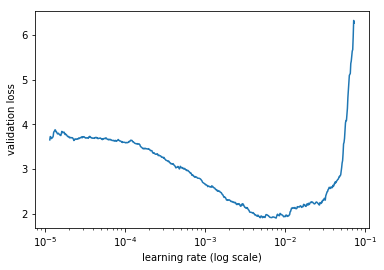

In [0]:
learn.sched.plot()

In [0]:
lr = 2e-3

# Class weights do not help ,Stratification might be useful.

But looks like ,class_weights do not give good results,hence dropping it.The other option I need to try is using StratifiedKFold .

In [0]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.387816   1.239709   0.135757   0.181391   0.222426  


[array([1.23971]),
 0.13575731497418245,
 0.18139138156986254,
 0.2224258885860596]

In [0]:
learn.crit = torch.nn.CrossEntropyLoss()


In [0]:
learn.set_data(get_data(299, bs)) 
learn.fit(lr, 2, cycle_len=1,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.932589   1.766415   0.442018   0.37616    0.073019  
    1      1.834503   1.703264   0.455465   0.452973   0.100754  
    2      1.76276    1.666432   0.465469   0.459408   0.10475   



[array([1.66643]),
 0.46546901893287435,
 0.4594084157870475,
 0.10474981013123506]

In [0]:
lrs = np.array([lr/1000,lr/100,lr])

In [0]:
learn.freeze_to(-2)

 74%|███████▍  | 432/581 [04:24<01:14,  1.99it/s, loss=6.8] 

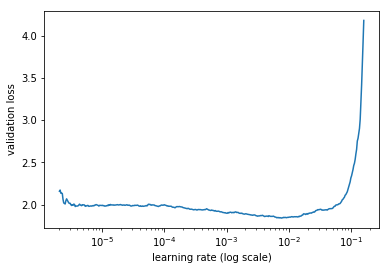

In [0]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [0]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.794009   1.656239   0.470525   0.494784   0.124795  


[array([1.65624]), 0.4705249569707401, 0.4947835247001529, 0.12479467742077796]

# Precision is improving but Recall is low.

Accuracy and precision are improving ,but Recall remains low. This could be due to missing annotations in many images.
But val_loss is still high.

In [0]:
learn.fit(lrs/5, 3, cycle_len=2,cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.435256   1.394394   0.545288   0.635535   0.239797  
    1      1.381799   1.382652   0.550022   0.640931   0.247199  
    2      1.387256   1.338477   0.560241   0.655918   0.264281  
    3      1.336033   1.302555   0.574225   0.666092   0.28664   
    4      1.252182   1.28896    0.576592   0.672842   0.295826  
    5      1.246087   1.28702    0.577775   0.675946   0.294296  
    6      1.258513   1.262567   0.587672   0.674761   0.31415   
    7      1.216929   1.238405   0.592083   0.683653   0.335879  
    8      1.146787   1.216251   0.598107   0.6783     0.355186  
    9      1.135972   1.201737   0.600904   0.680881   0.361598  
    10     1.084736   1.192358   0.60725    0.686992   0.369417  
    11     1.046773   1.188046   0.607466   0.689089   0.373786  
    12     1.043113   1.186086   0.609617   0.687942   0.3773    
    13     1.03719    1.185892   0.608111   0.692713   0.374948  


[array([1.18589]), 0.6081110154905336, 0.6927126633819856, 0.37494762457365133]

In [0]:
learn.unfreeze()

In [0]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.060684   1.182132   0.609725   0.689509   0.389663  


[array([1.18213]), 0.6097246127366609, 0.689509051479718, 0.3896630914154372]

In [0]:
learn.save("preci_66")

In [0]:
learn.load("preci_66")

In [0]:
x,y=next(iter(data.val_dl))
probs = F.softmax(predict_batch(learn.model,x),-1)


x,preds =  to_np(x),to_np(probs)
                           
preds = np.argmax(preds,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


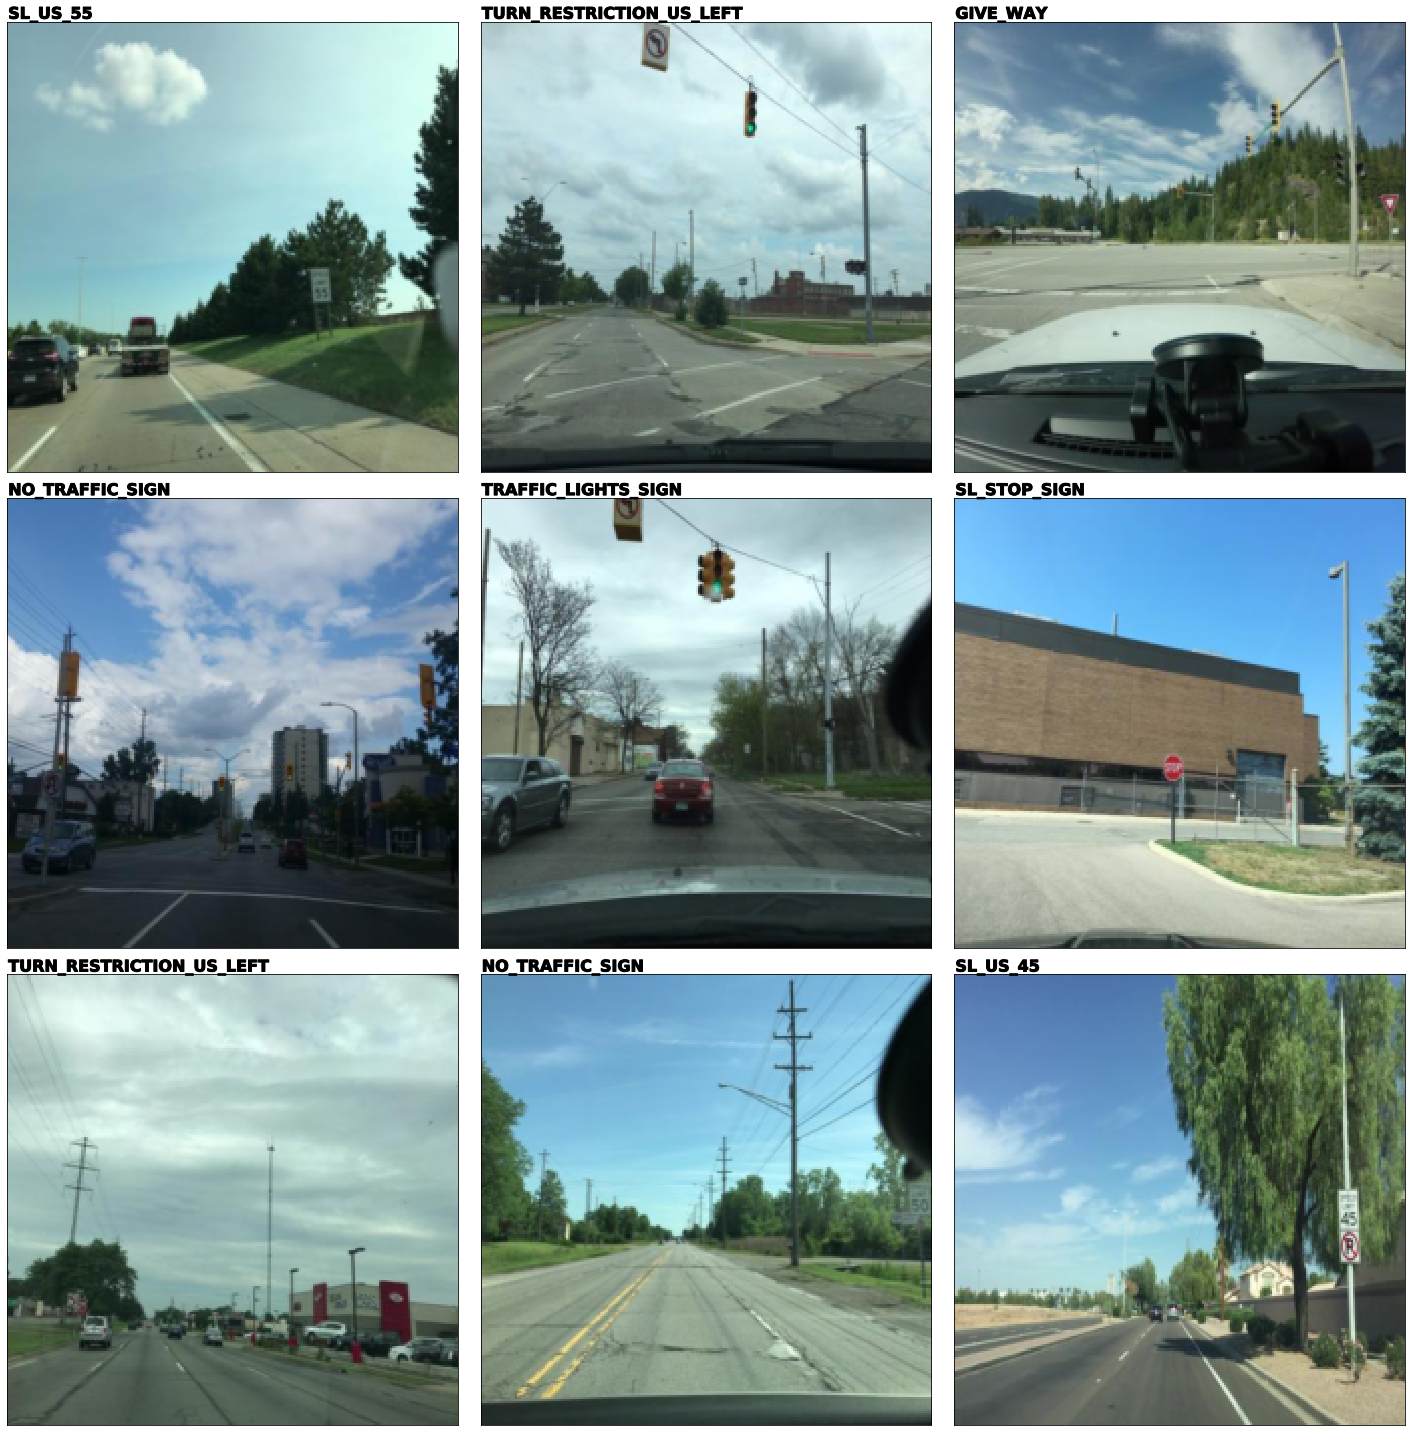

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=16,color ='white'):
    text = ax.text(*xy, txt,
        verticalalignment='bottom', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)  


fig,axes=  plt.subplots(3,3,figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i+15]
    b=data.classes[preds[i+15]]
    ax = show_img(ima,figsize=(12,12),ax=ax)
    draw_text(ax,(0,0),CLASS_NAME_DICT[int(b)],color='black')
plt.tight_layout()

# Training with 1Cycle.

This section is based on :https://github.com/sgugger/Deep-Learning/blob/master/Cyclical%20LR%20and%20momentums.ipynb

In [0]:
data = get_data(sz,512)

# Get the best weight decay by comparing with few values.

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-1,start_lr=0.01,end_lr=100)

 38%|███▊      | 220/581 [01:45<02:53,  2.08it/s, loss=9.45]

In [0]:
trn_lossesw1 = learn_1cycle.sched.losses
val_lossesw1 = learn_1cycle.sched.val_losses
lrsw1 = learn_1cycle.sched.lrs

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-2,start_lr=0.01,end_lr=100)


 36%|███▋      | 212/581 [01:43<02:55,  2.10it/s, loss=9.29]

In [0]:
trn_lossesw2 = learn_1cycle.sched.losses
val_lossesw2 = learn_1cycle.sched.val_losses
lrsw2 = learn_1cycle.sched.lrs

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-3,start_lr=0.01,end_lr=100)

 35%|███▍      | 202/581 [01:36<03:01,  2.09it/s, loss=9.34]

In [0]:
trn_lossesw3 = learn_1cycle.sched.losses
val_lossesw3 = learn_1cycle.sched.val_losses
lrsw3 = learn_1cycle.sched.lrs

In [0]:
learn_1cycle = ConvLearner.pretrained(f_model, data, precompute=False)
learn_1cycle.crit = F.nll_loss
learn_1cycle.opt_fn = optim.Adam
learn_1cycle.lr_find(wds=1e-4,start_lr=0.01,end_lr=100)

 35%|███▌      | 204/581 [01:36<02:57,  2.13it/s, loss=9.43]

In [0]:
trn_lossesw4 = learn_1cycle.sched.losses
val_lossesw4 = learn_1cycle.sched.val_losses
lrsw4 = learn_1cycle.sched.lrs

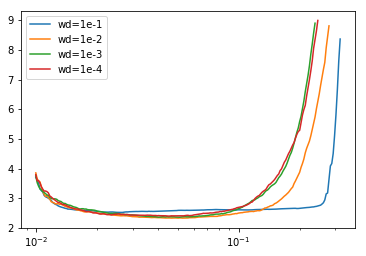

In [0]:
fig, ax = plt.subplots(1,1)
ax.plot(lrsw1[:-1],trn_lossesw1[:-1], label='wd=1e-1')
ax.plot(lrsw2[:-1],trn_lossesw2[:-1], label='wd=1e-2')
ax.plot(lrsw3[:-1],trn_lossesw3[:-1], label='wd=1e-3')
ax.plot(lrsw4[:-1],trn_lossesw4[:-1], label='wd=1e-4')
ax.set_xscale('log')
ax.legend(loc='upper left')

In [0]:
learn_1cycle  =  ConvLearner.pretrained(f_model, data,metrics=[accuracy,precision,recall], precompute=False)
learn_1cycle.crit  = F.nll_loss
learn_1cycle.opt_fn = optim.Adam

From the Graph , 1e-1 seems to run longest without losses going high . But it turns that with 1e-1 results are pretty bad. So using 1e-4 ,this needs to be investigated more.

In [0]:
learn_1cycle.lr_find(wds=1e-4,end_lr=100)

 67%|██████▋   | 391/581 [02:22<00:55,  3.40it/s, loss=9.82]

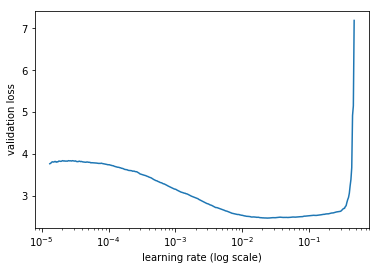

In [0]:
learn_1cycle.sched.plot(10,1)

In [0]:
lr = 5e-3

In [0]:
learn_1cycle.fit(lr,1,cycle_len=20,use_clr_beta=(10,20,0.95,0.85),wds=1e-4)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.995683   1.770484   0.438468   0.411697   0.091086  
    1      1.892659   1.719294   0.44901    0.441768   0.10674   
    2      1.844022   1.701557   0.44858    0.473948   0.109834  
    3      1.825081   1.684322   0.455357   0.482764   0.117124  
    4      1.802958   1.67139    0.468266   0.469057   0.11003   
    5      1.800384   1.68793    0.446751   0.458629   0.090259  
    6      1.798132   1.67963    0.460736   0.488624   0.131151  
    7      1.822205   1.689045   0.460413   0.46094    0.109651  
    8      1.794968   1.669528   0.454066   0.474353   0.125092  
    9      1.796761   1.682146   0.461166   0.443779   0.096054  
    10     1.753164   1.646696   0.469664   0.476667   0.112914  
    11     1.747649   1.635068   0.463425   0.515672   0.126542  
    12     1.730536   1.627593   0.473752   0.520822   0.13745   
    13     1.69614    1.597214   0.486553   0.527075   0.14175   
    14   

[array([1.5447]), 0.5019363166953529, 0.5686519197264491, 0.17267549742392194]

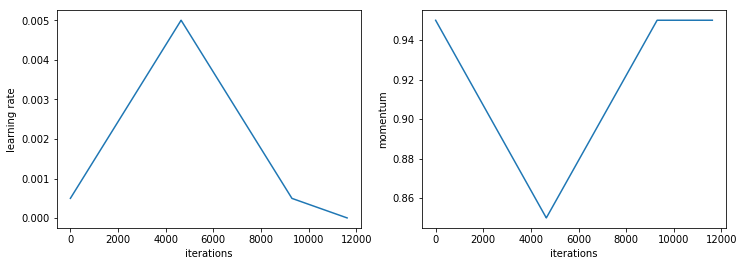

In [0]:
learn_1cycle.sched.plot_lr()

In [0]:
learn_1cycle.save("before_unfreeze_1cycle")

In [0]:
learn_1cycle.load("before_unfreeze_1cycle")

In [0]:
learn_1cycle.unfreeze()

In [0]:
learn_1cycle.fit(lrs=[lr/100, lr/10, lr],n_cycle = 1, wds=1e-4, use_clr_beta=(10,10,0.95,0.85),
          cycle_len=40)

epoch      trn_loss   val_loss   accuracy   precision  recall     
    0      1.306912   1.203535   0.601011   0.685359   0.321018  
    1      1.142794   1.08679    0.63651    0.716988   0.400401  
    2      0.988167   1.044168   0.659639   0.740746   0.4374    
    3      0.947385   1.00982    0.673193   0.723341   0.492672  
    4      0.881618   0.996637   0.677711   0.722014   0.530891  
    5      0.847063   0.977767   0.690404   0.750528   0.516083  
    6      0.806285   0.951826   0.697827   0.758087   0.532349  
    7      0.751054   0.966578   0.696859   0.720926   0.569827  
    8      0.707421   0.988202   0.691588   0.710404   0.570476  
    9      0.681825   0.955462   0.706756   0.721903   0.586669  
    10     0.65378    0.97944    0.707293   0.751441   0.56834   
    11     0.658462   0.93382    0.718158   0.745212   0.587669  
    12     0.606808   0.971665   0.725581   0.750705   0.591934  
    13     0.589256   0.965812   0.711381   0.709768   0.641541  
    14   

[array([1.12888]), 0.8023881239242685, 0.8178979720027205, 0.7549477207693636]

In [0]:
learn_1cycle.save("unfreeze_1cycle")

In [0]:
learn_1cycle.load("unfreeze_1cycle")

In [0]:
x,y=next(iter(data.val_dl))
probs = F.softmax(predict_batch(learn_1cycle.model,x),-1)


x,preds =  to_np(x),to_np(probs)
                           
preds = np.argmax(preds,-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


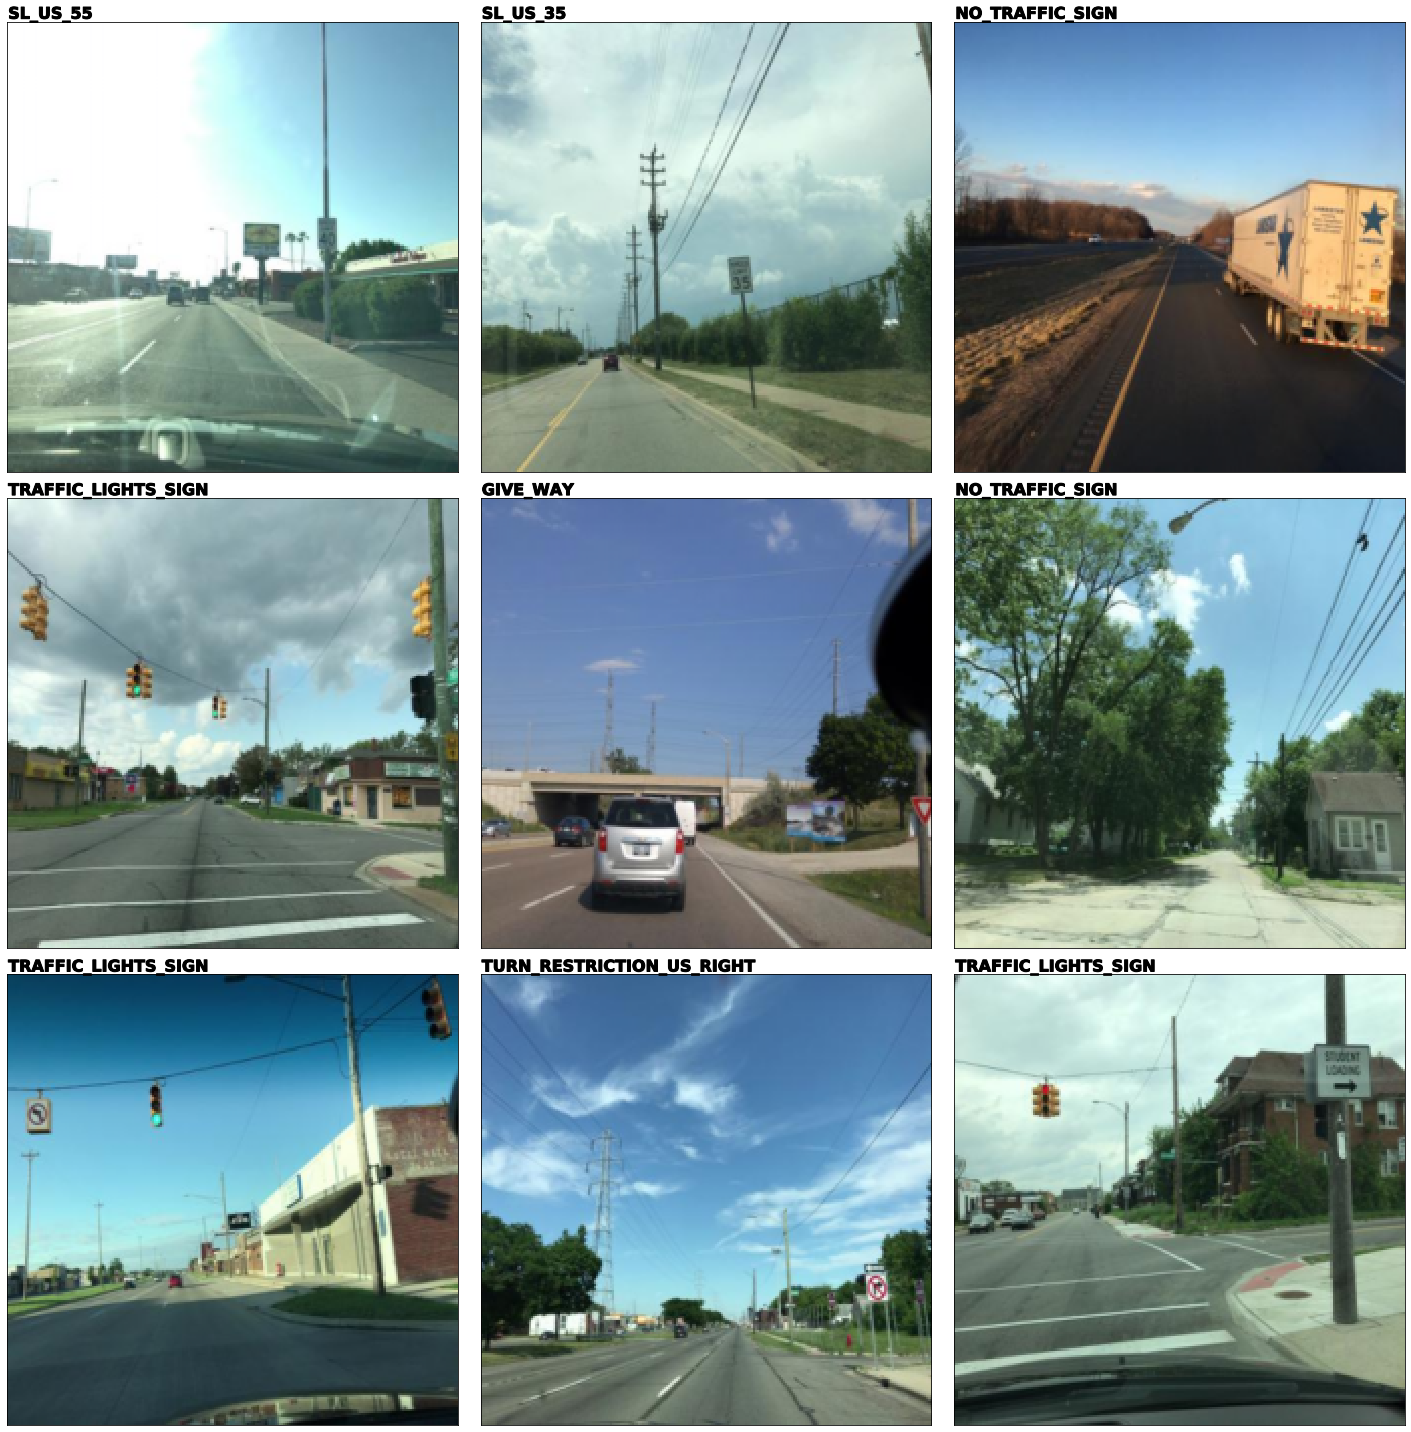

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=16,color ='white'):
    text = ax.text(*xy, txt,
        verticalalignment='bottom', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)  


fig,axes=  plt.subplots(3,3,figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ima=data.val_ds.denorm(x)[i+35]
    b=data.classes[preds[i+35]]
    ax = show_img(ima,figsize=(12,12),ax=ax)
    draw_text(ax,(0,0),CLASS_NAME_DICT[int(b)],color='black')
plt.tight_layout()